# **Movie Recommendation System**

In this project, we will focus on the collaborative filtering method to provide userwith presumable lists of movies: the user is recommended with similar tastes and preferences linked in the past.

## Part 0: Set-up Environment & Load Data

In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357277 sha256=5a8d6ca6bcc38f7cdc6cead38e5590e316b0f48100e7f098014e389e08f1746a
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [2]:
import numpy as np
import pandas as pd

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import matplotlib.pyplot as plt
import seaborn as sns

from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from collections import defaultdict

In [3]:
# https://drive.google.com/file/d/1JfQiWB1aDbv1ifKHmZKYkeziO_JEOmoE/view?usp=drive_link
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file = drive.CreateFile({'id':'1JfQiWB1aDbv1ifKHmZKYkeziO_JEOmoE'})
file.GetContentFile('ratings.csv')

ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)
df.shape

(100836, 3)

In [5]:
from surprise import Reader, Dataset
reader = Reader(line_format='user item rating timestamp', sep='\t')
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

## Part 1: Explore Data

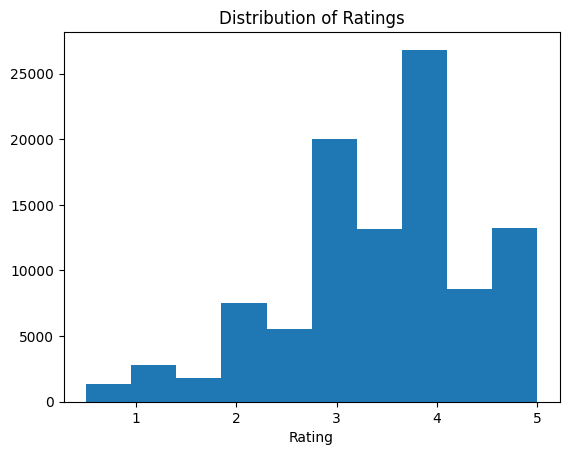

In [6]:
plt.hist(ratings['rating'])
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.show()

* Most users give ratings from 3 to 4.

In [7]:
top_raters = df.groupby('userID').count().sort_values(by='itemID', ascending=False).head(100)
top_raters

,itemID,rating
userID,,
414,2698,2698
599,2478,2478
474,2108,2108
448,1864,1864
274,1346,1346
...,...,...
63,271,271
325,270,270
169,269,269


In [8]:
min_raters = df.groupby('userID').count().sort_values(by='itemID', ascending=True).head(100)
min_raters

,itemID,rating
userID,,
442,20,20
406,20,20
147,20,20
194,20,20
569,20,20
...,...,...
335,28,28
396,28,28
471,28,28


* User "414" rated the most movies, 2698, while user "442" rated the least movies, 20.

## Part 2: Build Model

### Model Selection: SVD, NMF, KNN

In [9]:
benchmark = []
for algorithm in [SVD(), NMF(), KNNBasic()]:
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=True)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = pd.concat([tmp, pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm'])])
    benchmark.append(tmp)


Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8731  0.8842  0.8851  0.8808  0.0054  
Fit time          1.32    1.28    2.00    1.53    0.33    
Test time         0.25    0.37    0.31    0.31    0.05    
Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9338  0.9407  0.9318  0.9354  0.0038  
Fit time          2.85    2.32    2.30    2.49    0.26    
Test time         0.31    0.31    0.16    0.26    0.07    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9600  0.9590  0.9573  0.9588  0.0011  
Fit time          0.08    0.10    0.13 

In [10]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.880818,1.533196,0.311617
NMF,0.935433,2.490491,0.259994
KNNBasic,0.958757,0.101933,2.296454


* We choose SVD which has the least RMSE.

### Tuning Hyperparameters of SVD

Then, we tune algorithm parameters with GridSearchCV to find the best parameters for SVD.

In [11]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors': [25, 35, 45], 'n_epochs': [15, 20, 30], 'lr_all': [0.003, 0.008],
              'reg_all': [0.08, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

0.8661364186960762
{'n_factors': 45, 'n_epochs': 30, 'lr_all': 0.008, 'reg_all': 0.08}


### Train and Test Model

We use the **train_test_split()** to sample a trainset and a testset with given sizes, and use the accuracy metric of **RMSE**.

We’ll then use the **fit()** method which will train the algorithm on the trainset, and the **test()** method which will return the predictions made from the testset

In [12]:
from surprise import accuracy
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8686


0.8685980440861046

## Part 3: Model Evaluations

For each user and item, we have a prediction of rating. Let's check how good or bad all ratings are.

In [13]:
def get_Num_Items(User):
    try:
        return len(trainset.ur[trainset.to_inner_uid(User)])
    except ValueError:
        return 0

def get_Count_Users(Item):
    try:
        return len(trainset.ir[trainset.to_inner_iid(Item)])
    except ValueError:
        return

* User: user id
* Item: item id
* Rating: rating given by the user
* Est: rating estimated by the model
* NumItems: number of items rated by the user
* NumUsers: number of users rating the item
* Err: absolute difference between the estimated rating and the actual rating given by the user   

In [14]:
df_predictions = pd.DataFrame(predictions, columns=['User', 'Item', 'Rating', 'Est', 'Details'])
df_predictions['NumItems'] = df_predictions.User.apply(get_Num_Items)
df_predictions['NumUsers'] = df_predictions.Item.apply(get_Count_Users)
df_predictions['Err'] = abs(df_predictions.Est - df_predictions.Rating)
df_predictions

,User,Item,Rating,Est,Details,NumItems,NumUsers,Err
0,186,2064,4.0,4.443439,{'was_impossible': False},166,22.0,0.443439
1,301,1393,3.5,3.361100,{'was_impossible': False},83,61.0,0.138900
2,103,1093,3.5,3.709932,{'was_impossible': False},275,27.0,0.209932
3,232,50923,2.0,3.202424,{'was_impossible': False},647,1.0,1.202424
4,525,527,4.0,3.817023,{'was_impossible': False},374,165.0,0.182977
...,...,...,...,...,...,...,...,...
25204,414,6169,2.0,3.457738,{'was_impossible': False},2029,NaN,1.457738
25205,103,4886,3.5,3.979696,{'was_impossible': False},275,93.0,0.479696
25206,608,3527,3.0,3.317157,{'was_impossible': False},632,42.0,0.317157
25207,586,2,4.0,4.071558,{'was_impossible': False},159,74.0,0.071558


In [15]:
best_predictions = df_predictions.sort_values(by='Err')[:10]
worst_predictions = df_predictions.sort_values(by='Err')[-10:]
best_predictions

,User,Item,Rating,Est,Details,NumItems,NumUsers,Err
21389,543,1265,5.0,5.0,{'was_impossible': False},59,106.0,0.0
2370,543,364,5.0,5.0,{'was_impossible': False},59,126.0,0.0
2225,122,318,5.0,5.0,{'was_impossible': False},218,235.0,0.0
6234,43,1084,5.0,5.0,{'was_impossible': False},80,22.0,0.0
15242,452,1259,5.0,5.0,{'was_impossible': False},145,69.0,0.0
20996,171,1276,5.0,5.0,{'was_impossible': False},63,49.0,0.0
18601,25,177593,5.0,5.0,{'was_impossible': False},19,6.0,0.0
7247,515,318,5.0,5.0,{'was_impossible': False},23,235.0,0.0
7537,171,1104,5.0,5.0,{'was_impossible': False},63,15.0,0.0
3475,543,6377,5.0,5.0,{'was_impossible': False},59,99.0,0.0


In [16]:
worst_predictions

,User,Item,Rating,Est,Details,NumItems,NumUsers,Err
9024,594,7982,0.5,4.173364,{'was_impossible': False},170,3.0,3.673364
18128,580,3089,0.5,4.185804,{'was_impossible': False},333,10.0,3.685804
7039,594,4794,0.5,4.195860,{'was_impossible': False},170,2.0,3.695860
8456,105,4027,0.5,4.247765,{'was_impossible': False},541,71.0,3.747765
9005,393,27611,0.5,4.262169,{'was_impossible': False},90,11.0,3.762169
5981,258,87232,0.5,4.296777,{'was_impossible': False},16,34.0,3.796777
23176,51,4308,0.5,4.344296,{'was_impossible': False},257,39.0,3.844296
5694,210,296,0.5,4.536692,{'was_impossible': False},96,228.0,4.036692
7870,256,7099,0.5,4.585378,{'was_impossible': False},136,17.0,4.085378
13556,543,35836,0.5,4.753213,{'was_impossible': False},59,55.0,4.253213


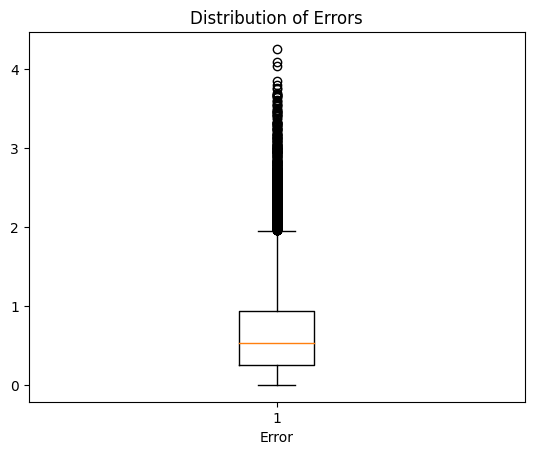

In [17]:
plt.boxplot(df_predictions['Err'])
plt.title('Distribution of Errors')
plt.xlabel('Error')
plt.show()

* Based on the box plot, we find that most errors clustered below 2 and there are some pretty surprising errors up to 4.

## Part 4: Recommendation

### Determine Threshold

In recommendation systems, we are interested in showing the top K items to users and so the best is to compute precision and recall on top K values instead of calculating on all the items.

The SVD algorithms can give us predicted rating of each movie, but we need to determine a threshold for recommendations.

In [18]:
final = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for User, _, true_r, Est, _ in predictions:
    if(true_r>=threshold):
      if(Est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(Est>=threshold):
        fp = fp+1
      else:
        tn = tn+1

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,25209,0,0,0,1.000000,1.000000,1.000000
1,0.5,25209,0,0,0,1.000000,1.000000,1.000000
2,1.0,24843,366,0,0,0.985481,1.000000,0.992688
3,1.5,24119,1069,10,11,0.957559,0.999544,0.978101
4,2.0,23605,1409,98,97,0.943672,0.995908,0.969086
5,2.5,21285,2754,652,518,0.885436,0.976242,0.928624
6,3.0,18293,2447,2316,2153,0.882015,0.894698,0.888312
7,3.5,10871,2720,7107,4511,0.799868,0.706735,0.750423
8,4.0,4188,878,12167,7976,0.826688,0.344295,0.486129
9,4.5,476,188,19532,5013,0.716867,0.086719,0.154721


* From table above, I may choose 2.5 as the threshold as it maintains a good balance between precision, reacall, and F-1 score.

**Threshold for relevant or recommended movies**
* Relevant: actual rating >= 2.5
* Irrelevant: actual rating < 2.5


* Recommend: predicted rating >= 2.5
* Not Recommend: predicted rating < 2.5

**Evaluation Metrics**

* Precision: proportions of recommended items that are relevant
* Recall: proportions of relevant items thare are recommended
* F-1 score: 2 * (precision * recall) / (precision + recall)

### Find Optimal K Recommendations

In [19]:
def precision_recall_at_k(predictions, k, threshold):
    # map the prediction to each user
    user_est_true = defaultdict(list)
    for User, _, true_r, Est, _ in predictions:
        user_est_true[User].append((Est, true_r))
    precisions = dict()
    recalls = dict()
    for User, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((Est >= threshold) for (Est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (Est >= threshold))
                              for (Est, true_r) in user_ratings[:k])
        precisions[User] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[User] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precisions, recalls

In [20]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
results

[{'K': 2, 'Precision': 0.9532786885245902, 'Recall': 0.17323497476043512},
 {'K': 3, 'Precision': 0.9483606557377051, 'Recall': 0.2486645859959969},
 {'K': 4, 'Precision': 0.9433060109289617, 'Recall': 0.31678281791278495},
 {'K': 5, 'Precision': 0.9392896174863392, 'Recall': 0.3799443484608226},
 {'K': 6, 'Precision': 0.9371038251366122, 'Recall': 0.43396751662355504},
 {'K': 7, 'Precision': 0.9339812646370016, 'Recall': 0.4795327004029426},
 {'K': 8, 'Precision': 0.9298536299765809, 'Recall': 0.5189190399316632},
 {'K': 9, 'Precision': 0.9279865990111906, 'Recall': 0.5535629950564498},
 {'K': 10, 'Precision': 0.9253090033827733, 'Recall': 0.5826121710398445}]

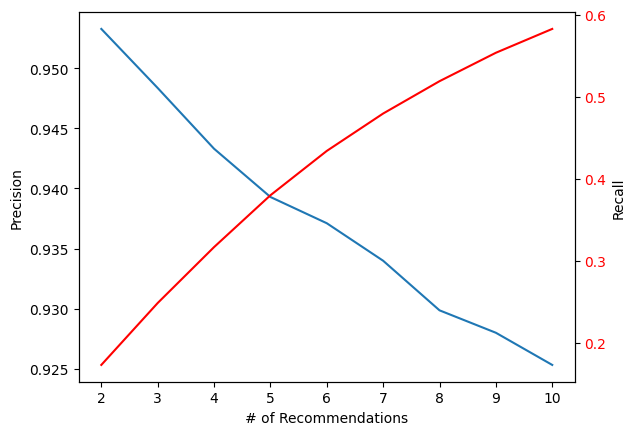

In [21]:
Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')

* Based on the trade-off between recall and precision, I choose 4 as the optimal number of recommendations.

### Make Recommendations

In [22]:
trainset = data.build_full_trainset()
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

# predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

# predict the ratings for testset
predictions = algo.test(testset)

In [23]:
def get_all_predictions(predictions):
    # map the predictions to each user.
    top_k = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_k[uid].append((iid, est))
    # sort the predictions for each user
    for uid, user_ratings in top_k.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
    return top_k

all_pred = get_all_predictions(predictions)

As we have all predicted ratings, we will filter out only top 4 movies for each user.

In [24]:
k = 4
for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:k]

In [25]:
tmp = pd.DataFrame.from_dict(all_pred)
tmp_transpose = tmp.transpose()
tmp_transpose

,0,1,2,3
1,"(318, 5.0)","(48516, 5.0)","(898, 5.0)","(2324, 5.0)"
2,"(27156, 4.560362026550421)","(3451, 4.5416517080606456)","(177593, 4.495742272751381)","(1041, 4.485937644054695)"
3,"(116897, 3.8995158265199366)","(1217, 3.854027943633891)","(7008, 3.847341390633273)","(87234, 3.7989057290893653)"
4,"(27156, 4.388541440910452)","(951, 4.309417560730792)","(1041, 4.303996926980361)","(56782, 4.299102089176651)"
5,"(3451, 4.411582711553263)","(1178, 4.399643928106386)","(1104, 4.397608532606072)","(177593, 4.383614036960672)"
...,...,...,...,...
606,"(177593, 4.423489440380928)","(1178, 4.361831882100691)","(1104, 4.354423788722223)","(5747, 4.333838482901423)"
607,"(27156, 4.649720403093791)","(1104, 4.636919251744794)","(6460, 4.632059051970839)","(1237, 4.58726283703713)"
608,"(27156, 4.590970163959637)","(3201, 4.578068489779041)","(3451, 4.574347567132101)","(71899, 4.565466226376035)"
609,"(3451, 4.263276410035071)","(177593, 4.196837144520445)","(27156, 4.187761593662027)","(1178, 4.158517034022591)"


Let's try one example.

In [26]:
def get_predictions(uid):
    results = tmp_transpose.loc[uid]
    return results

In [27]:
results = get_predictions(387)
results

,387
0,"(3451, 4.177025169272949)"
1,"(1178, 4.170707400271251)"
2,"(3266, 4.11793749169766)"
3,"(71899, 4.113680663285079)"


In [28]:
recommended_movie_ids=[]
for x in range(0, k):
    recommended_movie_ids.append(results[x][0])
recommended_movie_ids

[3451, 1178, 3266, 71899]

In [29]:
# https://drive.google.com/file/d/1lk0ghcWuWwnHFZnyY_d4alvW_K6xFtWn/view?usp=sharing
file = drive.CreateFile({'id':'1lk0ghcWuWwnHFZnyY_d4alvW_K6xFtWn'})
file.GetContentFile('movies.csv')

movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [30]:
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
recommended_movies

,movieId,title,genres
883,1178,Paths of Glory (1957),Drama|War
2453,3266,Man Bites Dog (C'est arrivé près de chez vous)...,Comedy|Crime|Drama|Thriller
2582,3451,Guess Who's Coming to Dinner (1967),Drama
7166,71899,Mary and Max (2009),Animation|Comedy|Drama


### Evaluate Recommendations

Let's compare results with the user history and see how relevant recommendations are.

In [31]:
ratings_history = df[df['userID'] == 387].sort_values("rating", ascending = False)
ratings_history

,itemID,userID,rating
59342,912,387,5.0
59404,1206,387,5.0
59324,750,387,5.0
59409,1212,387,5.0
60154,27773,387,5.0
...,...,...,...
60110,8387,387,0.5
59288,432,387,0.5
59365,1021,387,0.5
59272,317,387,0.5


In [32]:
history_movie_ids = ratings_history['itemID']
movies_history = movies[movies['movieId'].isin(history_movie_ids)]
movies_history[0:k]

,movieId,title,genres
9,10,GoldenEye (1995),Action|Adventure|Thriller
10,11,"American President, The (1995)",Comedy|Drama|Romance
28,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
30,31,Dangerous Minds (1995),Drama


In [33]:
recommended_movies

,movieId,title,genres
883,1178,Paths of Glory (1957),Drama|War
2453,3266,Man Bites Dog (C'est arrivé près de chez vous)...,Comedy|Crime|Drama|Thriller
2582,3451,Guess Who's Coming to Dinner (1967),Drama
7166,71899,Mary and Max (2009),Animation|Comedy|Drama


As the user history shows a preference of drama, our recommendation system correctly identifies this preference and make right movies to the user.

## Part 5: Summary


The Movie Recommender System project aims to provide personalized movie recommendations based on user preferences. The system utilizes a combination of algorithms, including Singular Value Decomposition (SVD), Non-Negative Matrix Factorization (NMF), and K-Nearest Neighbors (KNN), to generate accurate suggestions. The project is structured into the following phases:

1. **Set-Up and Data Loading**: The environment is configured, and the necessary data for building the recommendation model is loaded.
2. **Data Exploration**: A thorough exploratory data analysis (EDA) is conducted to understand user behavior, movie ratings, and patterns in the dataset.
3. **Model Building**: Various recommendation algorithms such as SVD, NMF, and KNN are explored. Hyperparameter tuning of SVD is performed to optimize model performance. The models are trained and tested using evaluation metrics.
4. **Model Evaluation**: The models are evaluated based on metrics like precision, recall, and accuracy to assess the recommendation quality.
5. **Recommendation Generation**: Thresholds are determined to find optimal K recommendations, which are then evaluated to refine and make recommendations for users.